# <a href="https://thetahat.ru/courses/ad" target="_top">Введение в анализ данных</a>


## Обработка естественного языка. Рекуррентные нейронные сети.

<a href="https://thetahat.ru/courses/ad/main/4/nn_simple_examples" target="_top">Ранее</a> мы поняли, как использовать готовые модули из PyTorch и опробовали слои `nn.Linear`, `nn.ReLU` для создания полносвязной сети. А на <a href="https://thetahat.ru/courses/ad/main/5/cv_classification" target="_top">прошлом занятии</a> мы научились строить сверточные нейронные сети для анализа изображений.

В данном ноутбуке мы научимся строить рекуррентные нейронные сети и решим с помощью них 2 задачи: посимвольная генерация имен и анализ тональности текста. В генерации рассмотрим 2 варианта работы с выходами RNN. Теорию можно посмотреть в <a href="https://thetahat.ru/files/ad/main/6/lec6.pdf" target="_blank" rel="noopener noreferrer">презентации</a>. Продолжаем работать с библиотекой `torch`, но добавится и новая  библиотека для обработки текстов: <a target="_top" href="https://www.nltk.org/">`nltk`</a>.


In [ ]:
# При необходимости установите необходимые библиотеки
# !pip install -q 'portalocker>=2.0.0' > null
# !python -m spacy download en > null
# !python -m spacy download de > null
# !pip install datasets

In [2]:
import re
import time
from collections import Counter, OrderedDict
from random import sample
from string import punctuation
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import names as names_data
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

sns.set(style="whitegrid", palette="Set2")
nltk.download("names")
nltk.download("stopwords")

device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Параметры и применение RNN

Напомним, как выглядит схема работы RNN и разберемся, какие гиперпараметры есть у простейшего рекуррентного слоя и как он выполняет вычисления.

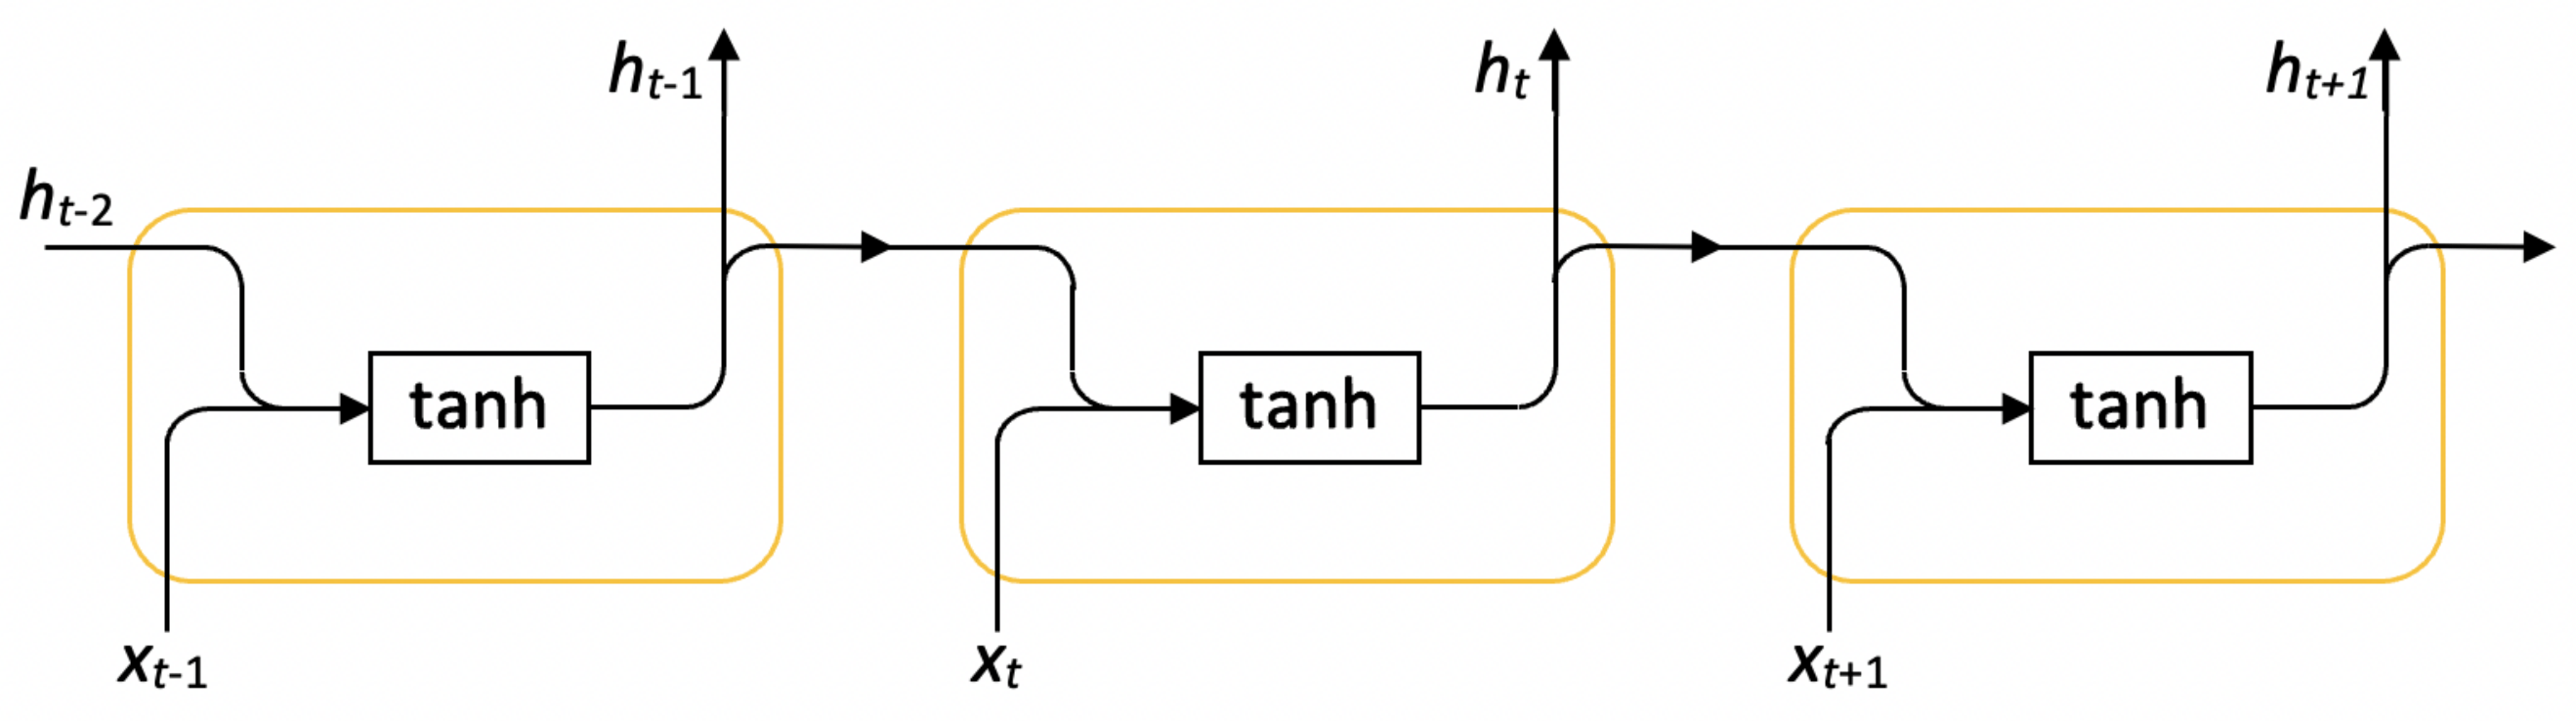

#### 1.1 Классическая RNN (Vanilla RNN)

**Вход:**
* очередное векторное представление (эмбеддинг) токена $x_t$
* предыдущее скрытое состояние $h_{t-1}$

**Выход:**
* новое скрытое состояние $h_t$

**Принцип работы**

Преобразование происходит по формуле:

$$h_t = \sigma(W_xx_t + W_hh_{t-1} + b_h),$$

где
* $x_{t}$ &mdash; эмбеддинг токена на позиции $t$: `[emb_dim, 1]`;

* $h_t$ &mdash; скрытое состояние: `[hid_dim, 1]`;

* $b_h$ &mdash; обучаемый вектор сдвига: `[hid_dim, 1]`;

* $W_x$ &mdash; обучаемая матрица для преобразования входов: `[hid_dim, emb_dim]`;

* $W_h$ &mdash; обучаемая матрица для преобразования скрытого состояния: `[hid_dim, hid_dim]`;

* $\sigma$ &mdash; нелинейная функция, по умолчанию `tanh`, применяется *поэлементно*;

Здесь $W_x, W_h, b_h$ &mdash; обучаемые параметры RNN-клетки, а `hid_dim`, `emb_dim` &mdash; гиперпараметры.

> В модуле `torch.nn` клетка Vanilla RNN представлена классом <a target="_top" href="https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html">`torch.nn.RNNCell`</a>. Его можно инициализировать следующим образом:
>
> `torch.nn.RNNCell(input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'tanh')`.
>
> Класс `RNNCell` возвращает только следующее скрытое состояние $h_t$ и содержит следующие поля:
> * `weight_ih` &mdash; матрица весов $W_x$;
> * `weight_hh` &mdash; матрица весов $W_h$;
> * `bias_ih`, `bias_hh` &mdash; векторы сдвигов, суммируемые в $b_h$.

---

Если же мы хотим решать задачу классификации последовательности, то мы можем применить линейный слой с функций softmax к **последнему** скрытому состоянию $h_T$, которое содержит всю информацию о последовательности, и получить предсказание вероятности:
$$\widehat{p} = \sigma(W_o h_T + b_o), $$

где $W_o, b_o$ &mdash; обучаемые параметры классификационной головы (линейного слоя).

---

Рассмотрим самый простой пример применения клетки RNN.


Для начала сгенерируем данные. Обычно это последовательность векторов фиксированной длины и размерности. Однако с прошлых занятий вы знаете, что нейронные сети обучаются с использованием стохастического градиентного спуска, поэтому в более общем случае на вход будет поступать некоторая подвыборка, батч с последовательностью векторов.

In [3]:
seq_len = 6  # Длина последовательности
batch_size = 3  # Количество последовательностей в батче
emb_size = 10  # Размерность эмбеддинга
hidden_size = 20  # Размерность скрытого состояния RNN

# Случайный вход размера (seq_len, batch_size, emb_dim), последовательности x_t
input = torch.randn(seq_len, batch_size, emb_size)

In [4]:
# Создадим ячейку
rnn = nn.RNNCell(input_size=emb_size, hidden_size=hidden_size)

# Начальное скрытое состояние размера (batch_size, hid_dim)
hidden_state = torch.randn(batch_size, hidden_size)

# Применяем ячейку к каждому элементу последовательности
for i in range(seq_len):
    hidden_state = rnn(input[i], hidden_state)

print(hidden_state)
print(hidden_state.shape)

tensor([[-0.3719, -0.0063,  0.0260,  0.4963,  0.3484, -0.4617,  0.4085,  0.1984,
          0.6802, -0.1591, -0.7564,  0.2332,  0.0843, -0.1252,  0.6911, -0.1905,
         -0.4302,  0.3189, -0.8415,  0.1088],
        [-0.1650,  0.0658,  0.0813, -0.5637,  0.4712, -0.3201,  0.3981,  0.4513,
          0.6555,  0.4416, -0.3270, -0.2817,  0.0302, -0.6167,  0.7265, -0.4448,
         -0.1518, -0.5918, -0.2719,  0.0510],
        [ 0.3914,  0.2035, -0.0160, -0.3387, -0.5313,  0.3724, -0.2426, -0.5116,
          0.4307,  0.7233,  0.4140, -0.3659,  0.2778,  0.6642,  0.3955,  0.3443,
          0.6372, -0.1775, -0.3342, -0.1123]], grad_fn=<TanhBackward0>)
torch.Size([3, 20])


#### 1.2 Модификации RNN

Немного затронем возможные модификации RNN.

**Двунаправленные RNN**

* Обрабатывают последовательность c помощью двух ячеек в двух направлениях (прямом и обратном), конкатенируя результаты.
* Таким образом, результатом работы будет не одно, а два скрытых состояния: для прямого и обратного прохода.
* Позволяют учитывать контекст из прошлого и будущего. Это полезно, например, для более глубокого анализа текста в той же задаче классификации.


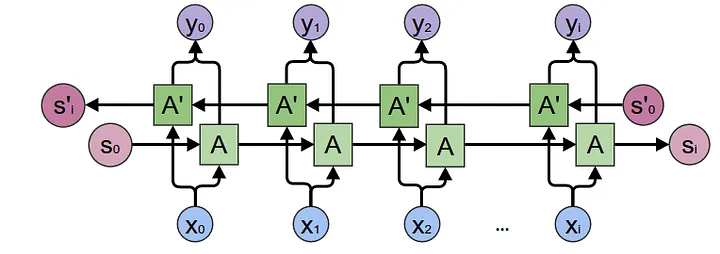


**Многослойные RNN**

* Состоят из нескольких последовательных слоев (RNN), каждый из которых использует выходные данные предыдущего слоя в качестве входных.
* Входная последовательность для слоя $k$ представляет собой последовательность скрытых состояний, полученных из предыдущего $k-1$ слоя.

![](picture.svg)



#### 1.3 RNN-слои

Вернёмся к базовой ячейке `RNNCell`. Чтобы обработать всю последовательность через эту ячейку, необходимо создать цикл, что совсем удобно. А если мы хотим использовать многослойные RNN, то сложность процесса возрастает.

Для упрощения задачи существует класс <a target="_top" href="https://pytorch.org/docs/stable/generated/torch.nn.RNN.html">`torch.nn.RNN`</a>.

> Параметры класса `RNN`:
>
> 1. `input_size` &mdash; размер эмбеддинга.
>
> 2. `hidden_size` &mdash; размер скрытого состояния.
>
> 3. `num_layers` &mdash; число рекуррентных слоёв, в случае использования многослойной RNN.
>
> 4. `nonlinearity` &mdash; функция активации &mdash; `'tanh'` или `'relu'`, по умолчанию: `'tanh'`.
>
> 5. `bias` &mdash; если установлен в `False`, то $b_h$ устанавливаются равными 0 и не обучается, по умолчанию: `True`.
>
> 6. `batch_first` &mdash; если `True`, то входные и выходные тензоры имеют размерность `(batch_size, seq_len, emb_dim)`, иначе `(seq_len, batch_size, emb_dim)`, по умолчанию: `False`.
>
> 7. `bidirectional` &mdash; использовать ли двунаправленную сеть.
>
> Класс `RNN` возвращает `h_n` и `output`.
>
> * `h_n` &mdash; скрытые состояния на **последний момент времени** со всех слоев и со всех направлений (forward и backward). Имеет размерность  `(num_layers * num_directions, batch_size, hidden_size)`.
>
>   В случае, если слой один и RNN однонаправленная, то это просто последнее скрытое состояние.
>
> * `output` &mdash; скрытые состояния **последнего слоя для всех моментов времени** $t$. Имеет размерность `(seq_len, batch_size, num_directions * hidden_size)`.
>     
>     В случае, если `bidirectional=True`, то то же самое и для обратного прохода.
    


Инициализируем `RNN` и применим её к последовательности случайных чисел.

In [5]:
layers_num = 2  # Кол-во слоев RNN

# Начальное скрытое состояние, по умолчанию будет нулевой вектор
first_hidden_state = torch.randn(layers_num, batch_size, hidden_size)

# Создадим многослоную RNN сеть и применим ее
rnn = nn.RNN(input_size=emb_size, hidden_size=hidden_size, num_layers=layers_num)
output, last_hidden_state = rnn(input, first_hidden_state)
print(output.shape, last_hidden_state.shape)

torch.Size([6, 3, 20]) torch.Size([2, 3, 20])


У нас однонаправленная сеть, поэтому размерность скрытых состояний последнего слоя `output: (seq_len, batch_size, hidden_size)`. При этом наша сеть двухслойная, поэтому размерность скрытых состояний последнего момента времени со всех слоев `(2, batch_size, hidden_size)`.

### 2. Простая языковая модель с использованием рекуррентных нейронных сетей


На <a href="https://thetahat.ru/files/ad/main/6/lec6.pdf" target="_blank" rel="noopener noreferrer">лекции</a> вы познакомились с устройством языковых моделей и основными их применениями. В данном обучающем ноутбуке построим простую языковую модель на основе рекуррентной нейронной сети и решим с её помощью простую задачу &mdash; **побуквенную генерацию имён**.

Загрузим датасет имён из модуля `nltk.corpus` для обучения сети.

In [ ]:
names = names_data.words(fileids=["male.txt"]) + names_data.words(fileids=["female.txt"])

#### 2.1 Обзор данных

Файл `names` содержит около 8000 имён из самых разных стран, записанных латинскими буквами.


In [ ]:
print("Всего имён:", len(names))
print("Примеры имён:")

for name in names[:10]:
    print(name)

Всего имён: 7944
Примеры имён:
Aamir
Aaron
Abbey
Abbie
Abbot
Abbott
Abby
Abdel
Abdul
Abdulkarim


При генерации слов или текстов необходимо задать **стоп-условие**, при выполнении которого генерация будет остановлена. Один из вариантов такого условия &mdash; *ограничение генерируемого текста по длине*.

Чтобы понять, каким значением ограничивать длину, посмотрим на распределение длин имён.

Максимальная длина: 15


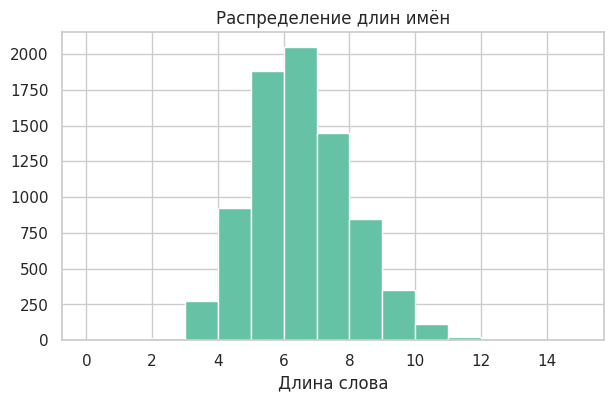

In [ ]:
MAX_LENGTH = max(map(len, names))
print("Максимальная длина:", MAX_LENGTH)

plt.figure(figsize=(7, 4))
plt.title("Распределение длин имён")
plt.hist(list(map(len, names)), bins=15, range=(0, 15))
plt.xlabel("Длина слова")
plt.show();

#### 2.2 Предобработка текста

Как вы знаете из <a href="https://thetahat.ru/files/ad/main/6/lec6.pdf" target="_blank" rel="noopener noreferrer">лекции</a>, сеть для генерации текстов должна по текущей последовательности токенов выдавать для всех возможных токенов вероятность быть следующим. Для этого необходимо найти все уникальные токены в обучающих данных.

In [ ]:
# запишем в tokens все возможные токены
tokens = set("".join(names))
tokens = list(tokens)

num_tokens = len(tokens)
print("Число токенов:", num_tokens)
print(tokens)

Число токенов: 55
['J', 'q', 'G', 'd', 'o', 'l', 'T', 'v', 'H', 'N', 'A', '-', 'Y', 'a', 'f', 'W', 'y', 'i', 'C', 'g', 'j', 'm', 'w', 't', 's', 'n', 'e', 'B', 'F', 'I', 'M', 'V', 'E', 'c', 'L', 'S', 'p', 'h', 'u', 'x', 'k', 'P', 'r', 'Q', 'b', 'R', 'X', 'Z', "'", 'K', 'U', 'O', 'D', ' ', 'z']


#### 2.3 Перевод символов в целочисленный формат

Сопоставим каждому токену из `tokens` число, чтобы с ним могла работать нейронная сеть.

In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
print(token_to_id)

{'J': 0, 'q': 1, 'G': 2, 'd': 3, 'o': 4, 'l': 5, 'T': 6, 'v': 7, 'H': 8, 'N': 9, 'A': 10, '-': 11, 'Y': 12, 'a': 13, 'f': 14, 'W': 15, 'y': 16, 'i': 17, 'C': 18, 'g': 19, 'j': 20, 'm': 21, 'w': 22, 't': 23, 's': 24, 'n': 25, 'e': 26, 'B': 27, 'F': 28, 'I': 29, 'M': 30, 'V': 31, 'E': 32, 'c': 33, 'L': 34, 'S': 35, 'p': 36, 'h': 37, 'u': 38, 'x': 39, 'k': 40, 'P': 41, 'r': 42, 'Q': 43, 'b': 44, 'R': 45, 'X': 46, 'Z': 47, "'": 48, 'K': 49, 'U': 50, 'O': 51, 'D': 52, ' ': 53, 'z': 54}


Батч, состоящий из последовательностей разной длины, невозможно объединить в один тензор, а это необходимо для проведения эффективных матричных операций на GPU, что существенно ускоряет вычисления. Чтобы решить эту проблему, рекомендуется дополнять короткие последовательности **специальным токеном**, а слишком длинные — обрезать.

Заполнение специальным токеном, например, пробелом, обычно осуществляется либо до максимальной длины последовательности в батче, либо до максимальной длины последовательности в датасете. При этом такие токены обычно маскируются, чтобы модель их игнорировала и они не оказывали влияния на предсказания.

In [ ]:
def to_matrix(
    lines: List[str],
    max_len: Optional[int] = None,
    pad: int = token_to_id[" "],
    dtype: str = "int32",
    batch_first: bool = True,
) -> np.ndarray:
    """
    Преобразует список текстов в целочисленную матрицу для нейросети.

    Параметры:
        lines: Список строк (например, имён). Каждая строка будет разбита на токены-символы.
        max_len: Максимальная длина последовательности. Если None, определяется как длина
               самого длинного текста в lines. Если текст длиннее max_len, он будет обрезан.
        pad: ID токена-заполнителя для выравнивания длин. По умолчанию пробел (token_to_id[" "]).
        dtype: Тип данных выходной матрицы. По умолчанию "int32".
        batch_first: Если True (по умолчанию), выходная матрица имеет размерность [batch, seq_len].
                     Если False, размерность [seq_len, batch].

    Возвращает:
        Целочисленная матрица формы:
        - [batch_size, max_len] если batch_first=True
        - [max_len, batch_size] если batch_first=False

    Пример:
        >>> token_to_id = {"a": 0, "b": 1, " ": 2}
        >>> to_matrix(["aaab", "abc"], max_len=5)
        array([[0, 0, 0, 1, 2],
               [0, 1, 2, 2, 2]], dtype=int32)
    """
    # Определение максимальной длины
    max_len = max_len or max(map(len, lines))

    # Инициализация матрицы с заполнением pad-токенами [batch_size, max_len]
    lines_ix = np.zeros([len(lines), max_len], dtype=dtype) + pad

    # Заполнение матрицы реальными токенами
    for i, line in enumerate(lines):
        truncated_line = line[:max_len]  # type: str
        line_ix = [token_to_id[c] for c in truncated_line]  # type: List[int]
        lines_ix[i, : len(line_ix)] = line_ix

    # Транспонирование при необходимости [seq_len, batch_size]
    if not batch_first:
        lines_ix = lines_ix.transpose()

    return lines_ix

Проверим работу функции на случайных именах из датасета.

In [ ]:
num_random_samples = 4
random_names = sample(names, num_random_samples)

for name, seq in zip(random_names, to_matrix(random_names)):
    print(f"Имя: {name}, последовательность токенов: {seq}")

Имя: Wally, последовательность токенов: [15 13  5  5 16 53 53]
Имя: Gilburt, последовательность токенов: [ 2 17  5 44 38 42 23]
Имя: Chrysa, последовательность токенов: [18 37 42 16 24 13 53]
Имя: Godard, последовательность токенов: [ 2  4  3 13 42  3 53]


#### 2.4 Рекуррентная архитектура для языковой модели

Мы реализуем наиболее простую архитектуру, состоящую из 3 частей:

* **Эмбеддинг-слой** &mdash; `nn.Embedding`. Эмбеддинг-слой превращает id токена из словаря `token_to_id` в **обучаемый** вектор чисел (эмбеддинг). Для токенов не из словаря обычно заводится спец. токен, который означает "отсутствует в словаре" и часто обозначается через `<unk>`.

* **Рекуррентный слой** &mdash; здесь может быть любая рекуррентная сеть. Как классическая RNN, так и ее модификации в виде LSTM и GRU, о которых вы сможете узнать подробнее на DS-потоке. Используется для обработки входной последовательности векторов.


* **Линейный слой** для предсказания следующего токена на основе предыдущих &mdash; это просто `nn.Linear`. Для предсказания токена на позиции $t+1$ будет использоваться скрытое состояние, полученное из RNN на шаге $t$, то есть $h_t$

Результатом работы нашей языковой модели будет тензор размера `(batch_size, seq_len, num_tokens)`.

In [ ]:
class CharRNNLoop(nn.Module):
    """RNN-модель для генерации текста/имён на уровне символов."""

    def __init__(
        self,
        num_tokens: int = num_tokens,
        emb_size: int = 16,
        hidden_size: int = 64,
    ) -> None:
        """
        Параметры:
            num_tokens: Размер словаря (количество уникальных символов), по умолчанию берётся из глобальной переменной
            emb_size: Размер векторного представления символов, default=16
            hidden_size: Размер скрытого состояния RNN, default=64
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        # Выставим batch_first, т. к. это проще
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Прямой проход модели.

        Параметры:
            x: Входной тензор индексов символов.
               Форма: (batch_size, seq_len)
               Тип элементов: int/long

        Возвращает:
            Логиты для предсказания следующего символа в каждой позиции.
            Форма: (batch_size, seq_len, num_tokens)

        Пример использования:
            >>> model = CharRNNLoop(num_tokens=100)
            >>> input_tensor = torch.randint(0, 100, (32, 10))
            >>> logits = model(input_tensor)  # (32, 10, 100)
        """
        # Проверка типа входных данных
        assert isinstance(x.data, torch.LongTensor), "Вход должен быть типа LongTensor"

        # Получим эмбеддинги для входов
        # (batch_size, max_name_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытые состояния для каждого
        # (batch_size, max_name_len, hidden_size)
        h_seq, _ = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, max_name_len, num_tokens)
        next_logits = self.hid_to_logits(h_seq)

        return next_logits

Зададим модель, лосс и оптимизатор.

In [ ]:
model = CharRNNLoop()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters())
history = []

Обсудим, что является таргетом. Напомним, что мы учим нейросеть предсказывать следующий токен на основе предыдущих. Для предсказания токена на позиции $t$ используются токены до $t-1$ включительно. Отметим, что в случае RNN предсказание будет делаться линейным слоем из скрытого состояния $h_{t-1}$.

* для $x_1, ..., x_{t-1}$ таргет это $x_{t}$.

* для $x_1, ..., x_{t}$ таргет это $x_{t + 1}$.

* и т.д.


Таким образом легко понять, что для входной последовательности $x_1, ..., x_T$, таргетом будет являться сама эта последовательность, но сдвинутая на один шаг.

Получаем:

* **Вход:** &emsp;$x_1, x_2, x_3, ..., x_{T-1}, x_{T}$.
* **Таргет:** &emsp;$x_2, x_3, x_4, ..., x_T$.

Обратим внимание, что самый первый токен мы предсказать не сможем, а после последнего токена предсказывать нечего. Для того, чтобы не терять первый и последний токен исходной последовательности, в словарь предварительно добавляют специальные токены начала и конца последовательности: `<bos>` / `<s>` и `<eos>` / `</s>`.

Соответственно, получаем

* **Вход:** &emsp;`<s>`$, x_1, x_2, ..., x_{T-1}, x_{T}, $ `</s>` \\
* **Таргет:** &emsp;$x_1, x_2, x_3, ..., x_T, $ `</s>`,

Для примера посчитаем лосс модели на одном батче.

In [ ]:
# Преобразуем текст в матричный вид
BATCH_SIZE = 32
# Сгенерируем случайный батч
batch_ix = to_matrix(sample(names, BATCH_SIZE), max_len=MAX_LENGTH)
# Преобразуем его в тензор
batch_ix = torch.LongTensor(batch_ix)

# Получим логиты для токенов
logits = model(batch_ix)

# Посчитаем лосс
loss = criterion(
    logits[:, :-1].contiguous().view(-1, num_tokens),
    batch_ix[:, 1:].contiguous().view(-1),
)
print(loss.item())
loss.backward()

3.960596799850464


Зафиксируем константы и напишем вспомогательную функцию для построения графика.

In [ ]:
MAX_LENGTH = 16  # Макс. длина посл-ти
NUM_TRAIN_STEPS = 3_000  # Кол-во шагов обучения
BATCH_SIZE = 32  # Размер батча


def plot_loss_curve(loss_history: List[float]):
    """Построение кривой обучения"""
    clear_output(True)
    plt.figure(figsize=(8, 5))
    plt.plot(history)
    plt.title("Лосс модели при обучении")
    plt.xlabel("Номер батча")
    plt.show()

Обучим модель.

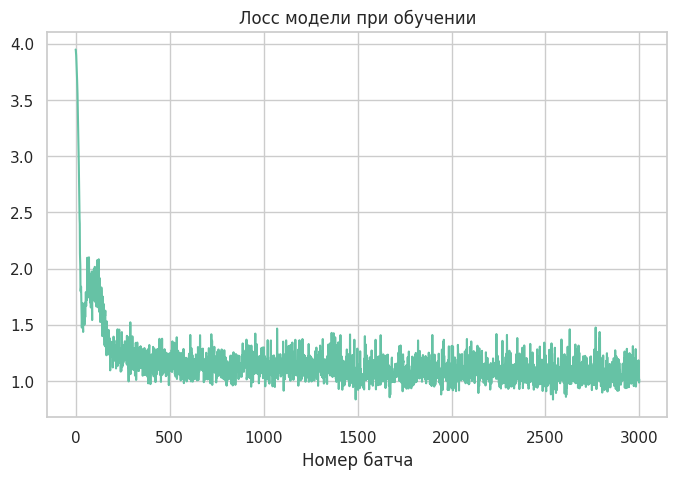

In [ ]:
for i in range(NUM_TRAIN_STEPS):
    batch_ix = to_matrix(sample(names, BATCH_SIZE), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logits_seq = model(batch_ix)

    # Считаем функцию потерь
    logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        logits.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )

    # Обратный проход
    loss.backward()
    opt.step()

    # Отрисовка графика лосса
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        plot_loss_curve(history)

&#x2753; **Вопрос** &#x2753;


> Почему в начале обучения модели значение лосса близко к 4?


<details>
 <summary> Кликни для показа ответа </summary>

> Логиты для всех классов, которых у нас $C=55$ (размер словаря), почти одинаковы из-за случайной инициализации весов. После $\text{softmax}$ имеем вероятности каждого класса $c$: $p_c \approx \frac{1}{C}$. Кросс-энтропия для одного сэмпла: $-\ln p_{c_{true}} = -\ln \frac{1}{C} = \ln C$. В итоге легко заметить, что $\ln 55 \approx 4$. Обратим внимание, что в PyTorch будет использован по-умолчанию именно натуральный логарифм.

</details><br/>


#### 2.5 Этап генерации


Рассмотрим процесс генерации текстов с помощью языковой модели. На каждом шаге $t$ модель, получив в качестве входных данных последовательность токенов $x_1, x_2,..., x_{t-1}$, вычисляет распределение вероятностей для *всех* возможных следующих токенов $x_t$ из заранее заданного словаря.

Задача методов генерации заключается в том, чтобы выбрать один токен $x_t$ из этого распределения для продолжения последовательности.

**1. Жадное сэмплирование (Greedy Sampling)**

Это самый простой и прямолинейный метод.

**Принцип работы:** На каждом шаге выбирается токен, имеющий **наибольшую** вероятность согласно предсказанию модели. Никакой случайности нет.

**2. Сэмплирование с температурой**

Этот метод вносит элемент случайности в процесс выбора следующего токена, позволяя генерировать более разнообразный и интересный текст. Он модифицирует исходное распределение вероятностей перед сэмплированием.

**Принцип работы:**

Пусть $\ell_i$ — это логит (сырой выход модели до применения функции softmax) для $i$-го токена в словаре. Оценка вероятности $P_i$ для этого токена вычисляется по следующей формуле:

$$P_i = \text{softmax}(\ell)_i = \frac{\exp\left({\ell_i}\right)}{\sum_{j \in V} \exp\left({\ell_j}\right)}$$

При использовании температуры $T$, мы "масштабируем" логиты $\ell_i$ следующим образом:

$$\ell'_i= \frac{\ell_i}{T}$$

На основе этого мы получаем новое распределение вероятностей, из которого будет производиться сэмплирование. Это распределение вычисляется с использованием масштабированных логитов следующим образом:

$$P'_i = \text{softmax}\left(\frac{\ell}{T}\right)_i = \frac{\exp\left({\left.\ell_i \right/ T}\right)}{\sum_{j}\exp\left({\left.\ell_j \right/ T}\right)}$$

Затем токен $x_t$ выбирается случайным образом в соответствии с распределением $P'$. То есть, вероятность выбора $i$-го токена равна $P'_i$.

**Влияние температуры:**

*   **T = 1:** Температура не оказывает никакого влияния на процесс, и $P'_i = P_i$. Отбор осуществляется в соответствии с распределением вероятностей, предсказанным моделью.

*   **0 < T < 1, низкая температура:** При делении на число меньше 1 разница между логитами становится более заметной. Распределение становится более "острым", то есть более вероятные токены получают более высокие вероятности, а менее вероятные — более низкие. В результате процесс приближается к **жадному отбору**, когда наиболее вероятные варианты выбираются с большей уверенностью. Модель становится более уверенной и предсказуемой, но также более склонной к повторениям.

*   **T > 1, высокая температура:** Деление на число больше 1 уменьшает разницу между логитами, делая распределение более "плоским" (uniform). Вероятности всех токенов становятся ближе друг к другу, и увеличивается вероятность выбора менее вероятных вариантов. Результат становится более **случайным, разнообразным и "креативным"**, однако возрастает риск грамматических ошибок и потери смысла.


**Выбор температуры:**

Температура $T$ — это ключевой параметр, который следует устанавливать в зависимости от конкретной задачи.

*   Для задач, требующих высокой точности и предсказуемости, таких как перевод или ответы на вопросы, обычно применяются низкие температуры в диапазоне от $0.2$ до $0.7$.
*   Для творческих задач, например, для генерации историй или стихов, могут быть уместны более высокие температуры в диапазоне от $0.7$ до $1.2$. Однако следует помнить, что слишком высокие значения могут привести к созданию бессвязного текста.

In [ ]:
def generate_sample(
    rnn_model: nn.Module,
    seed_phrase: str = " ",
    max_length: int = MAX_LENGTH,
    temperature: float = 1.0,
) -> str:
    """
    Генерирует последовательность символов (имя) с использованием RNN модели.

    Параметры:
        rnn_model (nn.Module):
            Обученная RNN модель для генерации последовательностей.
        seed_phrase (str, optional):
            Начальная фраза для инициализации генерации. По умолчанию " ".
        max_length (int, optional):
            Максимальная длина генерируемой последовательности. По умолчанию MAX_LENGTH.
        temperature (float, optional):
            Параметр температуры для управления случайностью предсказаний.
            Высокие значения увеличивают разнообразие, низкие делают предсказания более детерминированными.
            По умолчанию 1.0.

    Возвращает:
        str: Сгенерированная последовательность символов.

    Пример использования:
        >>> generate_sample(model, "A", max_length=10, temperature=0.5)
        'Aaren'
    """

    # Конвертируем начальные символы в индексы
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    # Посимвольная генерация
    for _ in range(max_length - len(seed_phrase)):
        # Получаем логиты от модели
        logits_next = rnn_model(x_sequence)

        # Применяем температуру и softmax
        p_next = torch.nn.functional.softmax(logits_next / temperature, dim=-1)
        p_next = p_next.data.numpy()[0, -1]  # Берем последний элемент последовательности

        # Сэмплируем следующий индекс
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        # Добавляем новый символ к последовательности
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    # Конвертируем индексы обратно в символы
    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Попробуем сгенерировать какие-нибудь имена.

In [ ]:
for _ in range(10):
    print(generate_sample(model, "Vas", max_length=5))

Vasse
Vasa 
Vasam
Vaso 
Vasab
Vasy 
Vasen
Vasoe
Vaspi
Vas  


In [ ]:
for _ in range(10):
    print(generate_sample(model, "Mipt"))

Miptiena        
Miptte          
Miptan          
Miptiyn         
Mipte           
Mipta           
Mipte           
Mipto           
Mipty           
Mipte           


**Проблема.** Заметим, что для того, чтобы сгенерировать следующий токен в модель каждый раз подается вся последовательность до текущего токена.

Попробуем написать более умную функцию `forward`, которая будет иметь возможность принимать не только всю последовательность векторов $x_1, \dots, x_n$, но и предыдущее скрытое состояние модели $h_0$. В таком случае у нас есть возможность передать это скрытое состояние сразу в RNN, а не вычислять его каждый раз заново. Это даст нам возможность генерировать токен $x_{t+1}$, используя только $x_t$ и скрытое состояние $h_{t-1}$, полученное с предыдущих шагов.


In [ ]:
class SmartCharRNNLoop(nn.Module):
    """Класс модели для генерации имён на основе LSTM,
    которая принимает на вход предыдущее скрытое состояние"""

    def __init__(
        self,
        num_tokens: int = num_tokens,
        emb_size: int = 16,
        hidden_size: int = 64,
    ) -> None:
        """
        Параметры:
            num_tokens: Размер словаря (количество уникальных символов), по умолчанию берётся из глобальной переменной
            emb_size: Размер векторного представления символов, default=16
            hidden_size: Размер скрытого состояния RNN, default=64
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        # Выставим batch_first, т. к. это проще
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)

    def forward(self, x: torch.Tensor, h0: Optional[torch.FloatTensor] = None) -> torch.Tensor:
        """Прямой проход модели.

        Параметры:
            x: Входной тензор индексов символов.
               Форма: (batch_size, seq_len)
               Тип элементов: int/long
            h0: Тензор с начальным скрытым состоянием (batch_size, 1, hidden_size)

        Возвращает:
            Логиты для предсказания следующего символа в каждой позиции.
            Форма: (batch_size, seq_len, num_tokens)

        Пример использования:
            >>> model = CharRNNLoop(num_tokens=100)
            >>> input_tensor = torch.randint(0, 100, (32, 10))
            >>> logits = model(input_tensor)  # (32, 10, 100)
        """

        # Получим эмбеддинги для входов
        # (batch_size, max_name_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN сеть, получим логиты и (h, c)
        # output.shape = (batch_size, max_name_len, hidden_size)
        # В отличии от CharRNNLoop, добавляется логика передачи скрытого состояния h0
        # если оно было передано в forward
        if h0 is not None:
            (
                output,
                h,
            ) = self.rnn(emb, h0)
        else:
            output, h = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, max_name_len, num_tokens)
        next_logits = self.hid_to_logits(output)
        return next_logits, h

Инициализируем модель и оптимизатор.

In [ ]:
model = SmartCharRNNLoop()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters())
history = []

Обучим улучшенную модель.

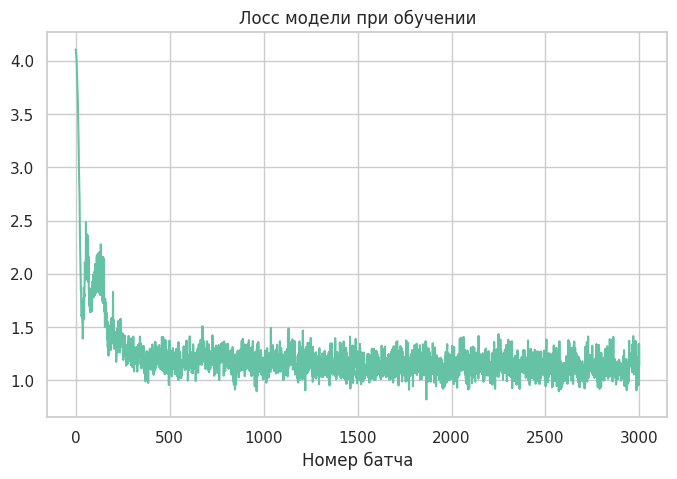

In [ ]:
for i in range(NUM_TRAIN_STEPS):
    batch_ix = to_matrix(sample(names, BATCH_SIZE), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logits_seq, _ = model(batch_ix)

    # Считаем функцию потерь
    logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        logits.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )

    # Обратный проход
    loss.backward()
    opt.step()

    # Отрисовка графика лосса
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        plot_loss_curve(history)

Напишем более умный метод генерации. На каждом этапе он берет скрытое состояние `h` с предыдущего этапа, а также сгенерированный на предыдущем этапе токен и предсказывает новый токен по полученным из RNN вероятностям.

In [ ]:
def smart_generate_sample(
    rnn_model: nn.Module,
    seed_phrase: str = " ",
    max_length: int = MAX_LENGTH,
    temperature: float = 1.0,
) -> str:
    """
    Генерирует последовательность символов с использованием RNN модели с оптимизацией через скрытые состояния.

    Особенность: использует скрытые состояния модели для эффективной пошаговой генерации,
    передавая их между итерациями вместо полного пересчета всей последовательности.

    Параметры:
        rnn_model (nn.Module):
            RNN модель с поддержкой скрытых состояний. Должна возвращать кортеж
            (логиты, (скрытое_состояние, ячейка)) при вызове
        seed_phrase (str, optional):
            Начальная фраза для инициализации генерации. По умолчанию " "
        max_length (int, optional):
            Максимальная длина генерируемой последовательности. По умолчанию MAX_LENGTH
        temperature (float, optional):
            Параметр температуры для управления случайностью предсказаний:
            - <1.0: более консервативные предсказания
            - >1.0: более случайные предсказания
            По умолчанию 1.0

    Возвращает:
        str: Сгенерированная последовательность символов

    Пример использования:
        >>> smart_generate_sample(model, "Al", max_length=5, temperature=0.7)
        'Alan'
    """

    # Конвертируем начальные символы в индексы
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    # Инициализируем скрытые состояния
    h = None

    for token_id in range(max_length - len(seed_phrase)):
        if token_id == 0:
            # Первый вызов - полный прямой проход
            logits_next, h = rnn_model(x_sequence)
        else:
            # Последующие вызовы - используем предыдущее скрытое состояния
            logits_next, h = rnn_model(x_sequence[:, -1:], h)

        # Применяем температурное масштабирование и softmax
        p_next = torch.nn.functional.softmax(
            logits_next[:, -1, :] / temperature, dim=-1
        ).data.numpy()[0, :]

        # Сэмплируем следующий индекс
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        # Добавляем новый символ к последовательности
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(smart_generate_sample(model, "Vas", max_length=5, temperature=0.9))

Vasic
Vas  
Vashh
Vashr
Vasnn
Vas  
Vas  
Vase 
Vast 
Vas  


In [ ]:
for _ in range(10):
    print(smart_generate_sample(model, "Mipt", max_length=8))

Mipthrl 
Miptan  
Miptk   
Miptna  
Mipti   
Miptane 
Mipthri 
Miptkhin
Miptha  
Mipt    


### 3. Задача классификации с использованием рекуррентных нейронных сетей


Посмотрим на то, как можно с помощью рекуррентной нейронной сети решить задачу <a target="_top" href="https://ru.wikipedia.org/wiki/Анализ_тональности_текста">sentiment analysis</a>.

**Sentiment Analysis** (анализ тональности) — это задача определения эмоциональной окраски текста. Обычно целью является определение тональности текста как положительной, отрицательной или нейтральной.

Пусть
* $X$ &mdash; набор текстовых данных, где каждый текст представлен в виде последовательности токенов;
* $Y$ &mdash; метки классов, где каждая метка обозначает эмоциональную окраску текста (например, `1` для положительного, `-1` для отрицательного, `0` для нейтрального).

Пусть у нас есть $m$ примеров в наборе данных. Каждый текст представлен в виде последовательности токенов. Чуть ранее мы выяснили, что для того, чтобы эффективно обрабатывать сразу батч из $m$ текстов, их нужно привести к фиксированной длине $n$ через обрезание и паддинг.

Тогда для текущей задачи:

- **Входные данные** $X$: Тензор размерности `(m, n)`, где $m$ &mdash; количество текстов, $n$ &mdash; фиксированная длина текстов, полученная обрезанием или дополнением.
- **Метки классов** $Y$: Вектор размерности `(m,)`, где каждый элемент $i$ принимает значения из множества $\{-1, 0, 1\}$.


**Цель**: построить модель $f(X)$, которая по входным текстам $X$ будет предсказывать метки классов $Y$.




Подробнее обсудим возможные стратегии выбора $n$ &mdash; максимальной длины последовательностей для **padding**.

1. Самый простой подход заключается в том, чтобы найти во всем датасете текст с максимальной длиной и дополнить все остальные последовательности до него.

2. Чуть более грамотно сначала сэмплировать батч и уже после этого дополнять паддингом последовательности до максимальной длины в батче. То есть в данном случае $n$ будет своя для каждого батча.

3. Наиболее продвинутым же является подход, при котором сэмплы приблизительно одинаковый длины группируют в отдельный бакет, а батч примеров сэмплируется из одного бакета. Таким образом, паддинг будет применяться реже, ведь последовательности будут очень схожи по длине.


&#x2753; **Вопрос** &#x2753;


> Какие могут быть преимущества и недостатки каждого из подходов?


<details>
 <summary> Кликни для показа ответа </summary>

> 1. Самый простой подход заключается в том, чтобы найти во всем датасете текст с максимальной длиной и дополнить все остальные последовательности до него.  
>   **Плюсы:**
>     - Самая простая в реализации
>
>   **Минусы:**
>     - Избыточные вычисления. Если 99% текстов короче 100 токенов, а один текст имеет 500, паддинг до 500 резко увеличивает объём данных и бесполезные вычисления.
>     - Требует много памяти, что критично для больших датасетов.

> 2. Чуть более грамотно сначала сэмплировать батч и уже после этого дополнять паддингом последовательности до максимальной длины в батче. То есть в данном случае $n$ будет своя для каждого батча.  
>   **Плюсы:**
>     - Экономия ресурсов. Паддинг адаптируется под каждый батч, уменьшая общее число токенов.
>     - Удобно для динамических данных (например, потоковой обработки).
>
>   **Минусы:**
>     - Нужно пересчитывать длину для каждого батча.
>     - Всё ещё есть избыточные вычисления, если тексты в одном батче сильно отличаются по длине.

> 3. Наиболее продвинутым же является подход, при котором сэмплы приблизительно одинаковый длины группируют в отдельный бакет, а батч примеров сэмплируется из одного бакета.
>
>   **Плюсы:**
>     - Минимизирует паддинг внутри батча.
>     - Ускоряет обучение за счёт однородности данных. Почти нет избыточных вычислений
>
>   **Минусы:**
>     - Сложность реализации: требуется предобработка данных и балансировка бакетов.

</details><br/>

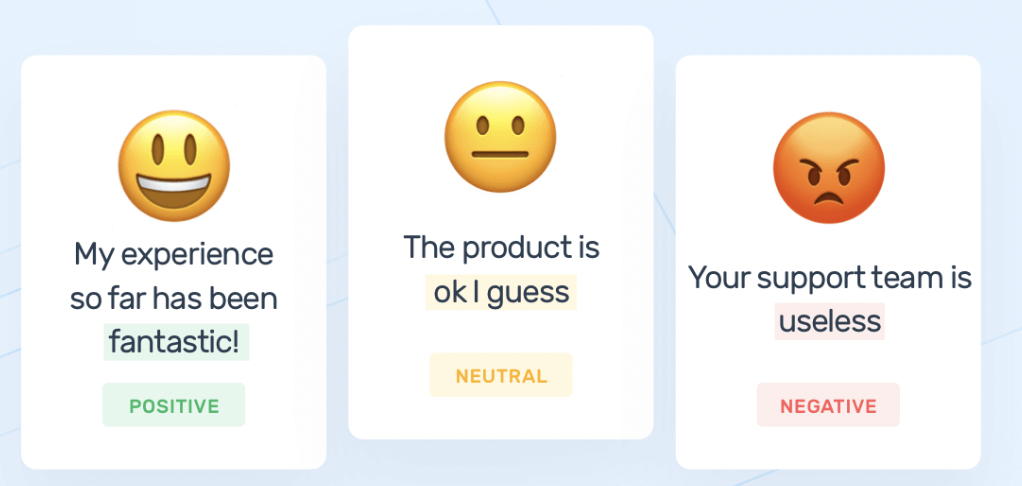

Сейчас для простоты демонстрации будем решать задачу классификации на **2 класса**:

* `0` &mdash; негативный отзыв;
* `1` &mdash; позитивный отзыв.


#### 3.1 Подготовка данных

Скачаем датасет отзывов к фильмам с сайта <a target="_top" href="https://www.imdb.com/">IMDB</a>

In [ ]:
data = load_dataset("scikit-learn/imdb", split="train").train_test_split(test_size=0.2, seed=42)

train_iter, test_iter = data["train"], data["test"]

train_dataset = list(train_iter)
test_dataset = list(test_iter)

Посмотрим на несколько примеров текстов.

In [ ]:
for i in range(4):
    print("Review:", train_dataset[i]["review"])
    print("Sentiment:", train_dataset[i]["sentiment"])
    print()

Review: The film disappointed me for many reasons: first of all the depiction of a future which seemed at first realistic to me was well-built but did only feature a marginal role. Then, the story itself was a weak copy of Lost in Translation. The Middle-Eastern setting, man with family meets new girl overseas, karaoke bar, the camera movements and the imagery - all that was a very bad imitation of the excellent Lost in Translation which had also credibility. This movie tries to be something brilliant and cultural: it is not. I wonder why Tim Robbins even considered doing this film!? The female main actress is awful - did she play the precog in Minority Report? And why do you have to show the vagina in a movie like this? Lost in Translation didn't have to show excessive love scenes. R-Rated just for this? This movie isn't even worth watching it from a videostore!
Sentiment: negative

Review: Can this "film" be considered as a film? Imagine the situation: somebody puts a handy cam over 

Зададим токенизатор, списки стоп-слов и пунктуации.

In [ ]:
def simple_tokenize(text):
    """Базовая предобработка."""
    # Приводим текст к нижнему регистру
    text = text.lower()
    # Убираем пунктуацию, заменяя её на пробел
    text = re.sub(r"[^\w\s]", " ", text)
    # Разбиваем текст на слова
    tokens = text.split()

    return tokens


stop_words = nltk.corpus.stopwords.words("english")  # Стоп-слова
print("Стоп-слова:", ", ".join(np.random.choice(stop_words, size=10)))

punc = list(punctuation)  # Пунктуация
print("Пунктуация:", punctuation)

Стоп-слова: above, isn, that, i, once, why, won, off, all, been
Пунктуация: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Зададим специальные токены:
- `<unk>` &mdash; токен для обозначения неизвестных токенов, которых нет в словаре;
- `<pad>` &mdash; токен для дополнения текста до фиксированной длины.

In [ ]:
# Объявим специальные токены
unk_token = "<unk>"
pad_token = "<pad>"

Создадим словарь используемых слов и отфильтруем редко используемые слова.

In [ ]:
# Зададим счетчики
counter = Counter()

# Посчитаем количество вхождений каждого токена
for text in train_iter:
    # Применяем simple_tokenize, чтобы разбить текст на токены.
    tokenized_text = simple_tokenize(text["review"])

    # Удаляем стоп-слова и пунктуацию
    filtered_tokens = [
        token for token in tokenized_text if token not in stop_words and token not in punc
    ]

    # Все оставшиеся токены добавляем в counter
    counter.update(filtered_tokens)

# Ограничение на словарь
MAX_VOCAB_SIZE = 25000
# Создадим словарь из MAX_VOCAB_SIZE самых частых токенов
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))
list(ordered_dict.items())[:10]

[('br', 161897),
 ('movie', 70342),
 ('film', 63721),
 ('one', 42863),
 ('like', 32075),
 ('good', 23726),
 ('time', 20197),
 ('even', 19989),
 ('would', 19887),
 ('story', 18575)]

Создадим словарь, добавив специальные токены: padding и unknown.

In [ ]:
class Vocabulary:
    """
    Класс для создания и управления словарем токенов,
        обеспечивающий преобразование
        между токенами и их индексами.
    """

    def __init__(self, word_freq: Dict[str, int]):
        """
        Инициализирует словарь.

        Параметры:
            word_freq: Словарь частот слов, где ключи - слова, значения - частоты.
        """
        self.itos = []  # Индекс -> слово
        self.stoi = {}  # Слово -> индекс
        self.build_vocab(word_freq)

    def build_vocab(self, word_freq: Dict[str, int]):
        """
        Заполняет словарь токенами из word_freq, игнорируя дубликаты.

        Параметры:
            word_freq: Словарь частот слов, где ключи - слова, значения - частоты.
        """
        for word in word_freq:
            self.append_token(word)

    def append_token(self, token: str):
        """
        Добавляет токен в словарь, если его еще нет в stoi.

        Параметры:
            token: Токен для добавления.
        """
        if token not in self.stoi:
            self.itos.append(token)
            self.stoi[token] = len(self.itos) - 1

    def __getitem__(self, token: str) -> int:
        """
        Возвращает индекс токена.
        Если токен отсутствует в словаре, возвращает индекс <unk>.

        Параметры:
            token: Токен, для которого нужно вернуть индекс.

        Возвращает:
            Индекс токена.
        """
        return self.stoi.get(token, self.stoi["<unk>"])

    def __len__(self) -> int:
        return len(self.itos)

    def set_default_index(self, index: int):
        """
        Установить индекс по умолчанию для отсутствующих токенов.

        Параметры:
            index: Индекс для установки в качестве дефолтного.
        """
        self.default_index = index

    def tokens_to_indices(self, tokens: List[str]) -> List[int]:
        """
        Преобразует список токенов в список индексов.

        Параметры:
            tokens: Список токенов для преобразования.

        Возвращает:
           Список индексов.
        """
        return [self[token] for token in tokens]

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        """
        Преобразует список индексов обратно в список токенов.

        Параметры:
            indices: Список индексов для преобразования.

        Возвращает:
            Список токенов.
        """
        return [self.itos[idx] if idx < len(self.itos) else "<unk>" for idx in indices]


# Создание словаря
vocab = Vocabulary(ordered_dict)

Напишем функцию для добавления специальных токенов.

In [ ]:
def add_special_tokens(vocab: Vocabulary) -> Tuple[Vocabulary, int, int]:
    """
    Функция для добавления специальных токенов в словарь.
    Специальные токены:
        - <unk>: Токен для обозначения неизвестных слов.
        - <pad>: Токен для паддинга последовательностей.

    Параметры:
        vocab: Словарь Vocabulary для добавления специальных токенов.

    Возвращает:
        vocab: Обновленный словарь Vocabulary.
        UNK_IDX: Индекс токена <unk>.
        PAD_IDX: Индекс токена <pad>.
    """
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)

    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
UNK_IDX_EN, PAD_IDX_EN

(25000, 25001)

Создадим датасет.

In [ ]:
class SentimentAnalysisDataset(Dataset):
    """
    Класс датасета анализа тональности.

    Наследование от torch.utils.data.Dataset обеспечивает интеграцию
    с torch.utils.data.Dataloader для автоматического разбиения на батчи.

    Требует обязательной реализации методов:
        __len__ для получения размера датасета
        __getitem__ для доступа к элементам по индексу
    """

    def __init__(self, texts: List[List[int]], labels: List[int], smart_pad_collate: bool = False):
        """
        Параметры:
            texts: корпус токенизированных текстов, на котором будет происходить обучение
            labels: истинные метки тональности текстов
            smart_pad_collate: активирует сортировку текстов по длине для уменьшения padding в батчах
        """
        self.texts = texts
        self.labels = labels

        if smart_pad_collate:
            self.texts.sort(key=len)

    def __len__(self) -> int:
        """
        Возвращает общее количество примеров в датасете.

        Возвращает:
            Количество элементов в датасете
        """
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[List[int], int]:
        """
        Возвращает один пример данных по индексу.

        Параметры:
            idx: Индекс примера

        Возвращает:
            Токенизированный текст
            Метку тональности
        """
        return self.texts[idx], self.labels[idx]

Используем знакомый паддинг до максимума в батче. Это просто и достаточно эффективно.

In [ ]:
def pad_collate(
    batch: List[Tuple[List[int], int]],
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Формирует тензоры из токенизированных текстов и меток, а также
    дополняет последовательности токенов до максимальной длины в батче с UNK_IDX

    Параметры:
        batch: Список примеров, где каждый пример - кортеж из:
            - Списка индексов токенов
            - Целевой метки

    Возвращает:
        Кортеж содержащий:
            - Тензор текстов с паддингом, shape = (batch_size, max_len)
            - Тензор меток, shape = (batch_size,)
    """
    texts, labels = zip(*batch)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(t) for t in texts]
    labels = torch.LongTensor(labels)

    # дополним до максимальной длины в батче
    texts_tensors = pad_sequence(texts_tensors, padding_value=PAD_IDX_EN, batch_first=True)

    return texts_tensors, labels

Токенизируем тексты.

In [ ]:
train_tokens = [vocab.tokens_to_indices(simple_tokenize(d["review"])) for d in train_dataset]
train_labels = [int(d["sentiment"] == "positive") for d in train_dataset]

# Разделим все токены и метки на train и test
train_tokens, valid_tokens, train_labels, valid_labels = train_test_split(
    train_tokens, train_labels, stratify=train_labels
)

train_data = SentimentAnalysisDataset(train_tokens, train_labels)
valid_data = SentimentAnalysisDataset(valid_tokens, valid_labels)

# Посмотрим пример из тренировочного датасета
print(train_data[0])

([25000, 881, 1102, 25000, 1, 25000, 25000, 25000, 25000, 2352, 25000, 25000, 25000, 25000, 25000, 25000, 381, 25000, 90, 25000, 25000, 25000, 473, 25000, 25000, 1, 25000, 582, 25000, 25000, 1318, 1888, 25000, 25000, 4392, 12416, 1, 853, 417, 225, 25000, 3, 3150, 25000, 2, 25000, 846, 25000, 191, 1287, 25000, 25000, 2129, 25000, 17, 1, 25000, 1503, 25000, 25000, 25000, 89, 2355, 21, 17, 24, 0, 0, 25000, 299, 25000, 25000, 1, 2214, 25000, 796, 25000, 1168, 941, 4438, 675, 1867, 5990, 25000, 2597, 3463, 25000, 1168, 5673, 25000, 3463, 25000, 917, 25000, 1454, 358, 176, 25000, 18, 17, 272, 25000, 740, 25000, 25000, 8363, 25000, 25000, 1, 261, 25000, 25000, 210, 25000, 25000, 4438, 25000, 43, 5126, 25000, 678, 25000, 25000, 25000, 358, 25000, 25000, 1058, 25000, 25000, 12686, 155, 108, 2663, 0, 0, 25000, 110, 25000, 192, 22795, 1830, 13556, 25000, 25000, 43, 25000, 441, 21, 155, 99, 25000, 25000], 1)


Как видим, сэмпл состоит из последовательности токенов, среди которых можно увидеть много `<unk>`-токенов, так же целевой бинарной метки.

Размер получившегося словаря:

In [ ]:
num_tokens = len(vocab)
num_tokens

25002

Посмотрим на распределение количества токенов в тексте.

Максимальная длина: 2525


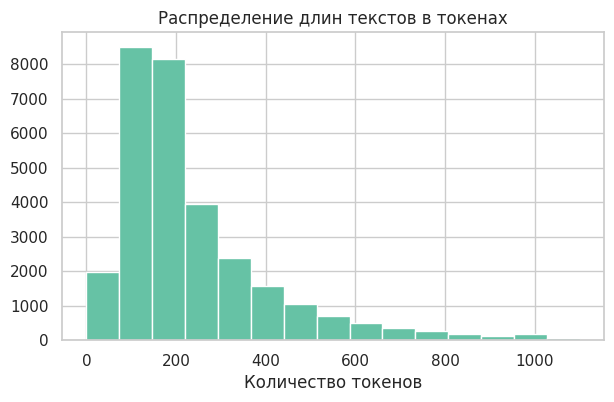

In [ ]:
lens = [len(row) for row in train_tokens]
print("Максимальная длина:", max(lens))

plt.figure(figsize=(7, 4))
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Количество токенов")
plt.hist(lens, bins=15, range=(0, 1100))
plt.show()

In [ ]:
BATCH_SIZE = 32  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

In [ ]:
BATCH_SIZE = 32  # размер батча

# Инициализация загрузчиков данных для тренировочного и валидационного наборов
train_loader = DataLoader(
    # Используем тренировочный датасет, реализующий интерфейс torch.utils.data.Dataset
    train_data,
    batch_size=BATCH_SIZE,
    # Перемешивание данных перед каждой эпохой
    shuffle=True,
    # Специальная функция для обработки батча, в нашем случае паддинг текстов
    collate_fn=pad_collate,
)
valid_loader = DataLoader(
    # Используем валидационный датасет, реализующий интерфейс torch.utils.data.Dataset
    valid_data,
    batch_size=BATCH_SIZE,
    # Отключаем перемешивание для стабильной оценки
    shuffle=False,
    # Специальная функция для обработки батча, в нашем случае паддинг текстов
    collate_fn=pad_collate,
)

#### 3.2 Архитектура рекуррентной нейронной сети для задачи sentiment analysis

Мы реализуем наиболее простую архитектуру, состоящую из 3 частей:

* **Эмбеддинг-слой** &mdash; преобразует дискретные индексы токенов в плотные векторные представления.
* **Рекуррентный слой** &mdash; обрабатывает последовательность эмбеддингов. Здесь может быть любая рекуррентная сеть (например, Vanilla RNN, LSTM или GRU).
* **Линейный слой** &mdash; преобразует финальное скрытое состояние в логиты классов.

> В отличие от прошлой модели сейчас мы делаем предсказание класса **для всей последовательности**, используя *последнее скрытое состояние* $h_T$, так как в нем сагрегирована информация из всего текста.

In [ ]:
class SimpleLSTMClassifier(nn.Module):
    """Модель для классификации последовательностей на основе LSTM."""

    def __init__(
        self,
        num_tokens: int,
        emb_size: int = 512,
        rnn_num_units: int = 64,
        num_classes: int = 2,
    ):
        """
        Параметры:
            num_tokens: Размер словаря (количество уникальных токенов)
            emb_size: Размерность эмбеддингов
            rnn_num_units: Размер скрытого состояния LSTM
            num_classes: Количество классов для классификации
        """
        super(self.__class__, self).__init__()

        # Инициализация слоя эмбеддингов с учетом паддинг-токена
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)

        # Инициализация LSTM слоя.
        # batch_first=True обеспечивает формат входных данных (batch, seq_len, features),
        # если его не указать, то будет (seq_len, batch, features)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)

        # Инициализация финального классификатора
        self.classifier = nn.Linear(rnn_num_units, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход модели.

        Параметры:
            x: Входной тензор индексов токенов (batch_size, sequence_length)

        Возвращает:
            Тензор логитов для классификации (batch_size, num_classes)
        """
        # x.shape = (batch_size, max_pad_len)

        # Получим эмбеддинги для входов
        # emb.shape = (batch_size, max_pad_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # h_state.shape = (1, batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # logits.shape = (batch_size, num_tokens)
        logits = self.classifier(h_state.squeeze(0))
        return logits

Напишем вспомогательные функции для подсчета точности (`binary_accuray`), обучения (`train`) и тестирования (`evaluate`) модели на 1 эпохе. Функция `epoch_time` позволит измерять время прохождения 1 эпохи.

In [ ]:
def binary_accuracy(preds: torch.Tensor, y: torch.Tensor) -> float:
    """
    Возвращает точность модели.

    Параметры:
        preds: ненормированные предсказания модели (логиты)
        y: Истинные метки классов в виде целых чисел

    Возвращает:
        Точность в диапазоне [0, 1]
    """

    # Преобразуем логиты в вероятности и округляем до 0/1
    rounded_preds = torch.round(torch.sigmoid(preds))

    # Считаем количество правильных предсказаний
    correct = (rounded_preds == y).float()

    # Вычисляем долю правильных ответов
    acc = correct.sum() / len(correct)
    return acc


def train(
    model: nn.Module,
    iterator: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    loss_history: List[float],
) -> Tuple[float, float]:
    """
    Функция 1 эпохи обучения модели и подсчёта её точности.

    Параметры:
        model: Обучаемая нейросетевая модель
        iterator: Итератор по батчам обучающего датасета
        optimizer: Оптимизатор для обновления весов
        criterion: Функция потерь (например, BCELoss)
        loss_history: Список для сохранения истории лосса

    Возвращает:
        Средние значения loss и accuracy за эпоху
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:
        # Чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()

        # Переносим batch на GPU
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)

        # Получим предсказания модели
        predictions = model(texts).squeeze(1)

        # Посчитаем метрики
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)

        # Сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # Выполним шаг оптимизатора
        optimizer.step()

        # Обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(
    model: nn.Module,
    iterator: DataLoader,
    criterion: nn.Module,
    loss_history: Optional[List[float]] = None,
) -> Tuple[float, float]:
    """Оценка модели на валидационном/тестовом наборе данных.

    Args:
        model: Оцениваемая модель
        iterator: Итератор по батчам валидационного датасета
        criterion: Функция потерь
        loss_history: Опциональный список для истории потерь

    Возвращает:
        Средние значения loss и accuracy
    """

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Отключим подсчёт градиентов на валидации
    with torch.no_grad():
        for batch in iterator:
            # Переносим batch на GPU
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)

            # Получим предсказания модели
            predictions = model(texts).squeeze(1)

            # Посчитаем метрики
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)

            # Обновим метрики
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if loss_history is not None:
                loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time: float, end_time: float) -> Tuple[int, int]:
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры:
        start_time: Время начала в секундах
        end_time: Время окончания в секундах

    Возвращает:
        Минуты и секунды
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Объединим эти функции в единый цикл обучения:

In [ ]:
def training_loop(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    n_epochs: int = 10,
):
    """
    Функция для обучения нейронной сети.

    Параметры:
        model: Обучаемая нейросетевая модель
        train_loader: Итератор по батчам обучающего датасета
        valid_loader: Итератор по батчам валидационного датасета
        optimizer: Оптимизатор для обновления весов
        criterion: Функция потерь
        n_epochs: Количество эпох
    """

    best_valid_loss = float("inf")
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, loss_history)
        acc_history.append(train_acc)

        # Оценим точность модели на тестовом датасете
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loss_history)
        val_acc_history.append(valid_acc)

        # Посчитаем время работы одной эпохи
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Отобразим графики loss'ов
        clear_output(True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.title("Train Loss")
        plt.xlabel("Номер батча")
        plt.subplot(1, 3, 2)
        plt.plot(val_loss_history, color="tab:orange")
        plt.title("Valid Loss")
        plt.xlabel("Номер батча")
        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "model_checkpoint.pt")

        # Отрисуем значение точности от эпохи
        plt.subplot(1, 3, 3)
        plt.plot(acc_history, label="Train")
        plt.plot(val_acc_history, label="Valid")
        plt.legend()
        plt.title("Accuracy")
        plt.xlabel("Номер эпохи")
        plt.show()

        print(f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s")

Теперь можем инициализировать модель и обучить ее.

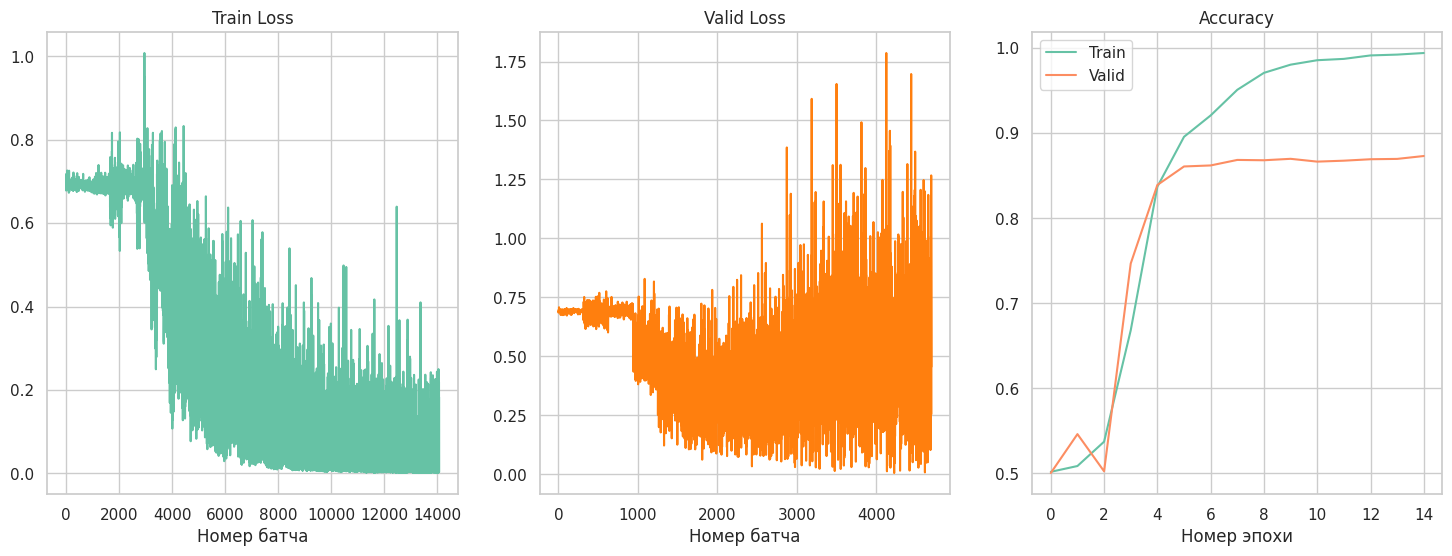

Номер эпохи: 15 | Время обучения эпохи: 0m 41s


In [ ]:
model = SimpleLSTMClassifier(
    num_tokens=num_tokens,
    emb_size=128,
    rnn_num_units=256,
    num_classes=1,
).to(device)

# У нас задача бинарной классификации, будем использовать BCEWithLogitsLoss,
# так как наша модель возвращает именно логиты
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = []

training_loop(model, train_loader, valid_loader, optimizer, criterion, n_epochs=15)

Посмотрим, что выдает наша модель на конкретных отзывах. Для начала получим предсказания на одном батче из тестовой выборки.

In [ ]:
data_batch, labels_batch = next(iter(valid_loader))

# Применяем модель, получаем предсказания
with torch.no_grad():
    preds = torch.round(torch.sigmoid(model(data_batch.to(device))))

Теперь выведем тексты и предсказания для них. При генерации батчей мы убирали пунктуацию, поэтому сейчас не сможем посмотреть на изначальный текст. Но суть уловить все еще можно:

In [ ]:
label_mapping = ["negative", "positive"]

# Выведем предсказания для 5 случайных примера из тестового батча
indices = torch.randint(low=0, high=len(data_batch), size=(5,))
for idx in indices:
    print("=" * 20)
    print("Text:")
    text = " ".join(
        [
            token
            for token in vocab.lookup_tokens(data_batch[idx].tolist())
            if token not in ["<unk>", "<pad>"]
        ]
    )
    print(text)
    print(f"Predicted label: {label_mapping[int(preds[idx].item())]}")
    print(f"True label: {label_mapping[labels_batch[idx].item()]}")
    print()

Text:
made 2000 released video 5 years later reason wonder could confusing storyline incomprehensible dialogue said oliver martinez annoying editing got think plot mary michelle forbes oliver martinez go mystical road trip meet lot wacky characters avoid evil ones movie looks great lot style substance movies trying subtle call attention unanswered plot developments weak special effects br br fooled cover willem dafoe 2 minutes
Predicted label: negative
True label: negative

Text:
long time ago galaxy far far away boy two years old original star wars film released remember first seeing movie also remember life remember first star wars themed gift got full action figures original set young fully appreciate special gift would years later would get day goes one best gifts ever received another box full action figures ten final twelve needed complete collection legendary boy family last action figure needed anakin skywalker stopped produced carried stores boy went ten years got college tryi

**Вывод:** В этом ноутбуке мы научились представлять тексты в численном виде, обучили несколько моделей на основе `nn.LSTM`, генерирующих имена по данному началу. Также научились решать задачу анализа тональности отзывов к фильмам, которая по своей сути является частным случаем задачи классификации текста.


Во <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part2" target="_top">второй части</a> семинара мы познакомимся с основами запуска современных LLM через библиотеку `transformers` и применим уже небольшую современную модель к решению задачи анализа тональности.